In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import binom
import pickle
from sklearn.cluster import KMeans
exec(open('../../analysis/ppVAF_calculations/ppVAF_utils.py').read())

set2_colors = plt.get_cmap("Set2").colors
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# root directory where processed mutation data are stored
# if using the zenodo data, this should point to the location of the base zenodo directory (including wes, wgs, etc subfolders)
data_dir = ""

# directory where the simulation data and table with clonal counts and polyclonal calls are saved
# defaults to path in repo relative to current WD
output_dir = "../../data/clonal_count_estimation/"

annot_dir = "../../data/scATACseq_annotations/"
purity_dict = pickle.load(open(annot_dir+"scATAC_purities.p", "rb"))

save_plots = False
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

In [3]:
filtered_maf_WGS = pd.read_csv(data_dir+"HTAN_WGS_filtered_ppVAFs.maf", sep="\t")
filtered_maf_WES = pd.read_csv(data_dir+"HTAN_WES_filtered_ppVAFs.maf", sep="\t")

all_clonal = pd.read_csv(output_dir+"clonal_SNVs_WES_WGS.csv", index_col=0)

WGS_samples = list(set(filtered_maf_WGS["Tumor_Sample_Barcode"]))
sample_to_stage = dict(zip(filtered_maf_WGS["Tumor_Sample_Barcode"], filtered_maf_WGS["Stage"]))
sample_to_stage.update(dict(zip(filtered_maf_WES["Tumor_Sample_Barcode"], filtered_maf_WES["Stage"])))

only_SNVs_WGS = filtered_maf_WGS[filtered_maf_WGS["Variant_Type"]=="SNP"]
only_SNVs_WES = filtered_maf_WES[filtered_maf_WES["Variant_Type"]=="SNP"]
true_subclonal_WGS = only_SNVs_WGS[only_SNVs_WGS["Stage"]=="Mucosa"]
true_subclonal_WES = only_SNVs_WES[only_SNVs_WES["Stage"]=="Mucosa"]

simulated_clonal_WGS = pd.read_csv(output_dir+"simulated_clonal_WGS.csv")
simulated_clonal_WES = pd.read_csv(output_dir+"simulated_clonal_WES.csv")

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (85,87,88,90) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


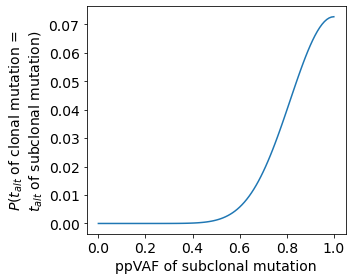

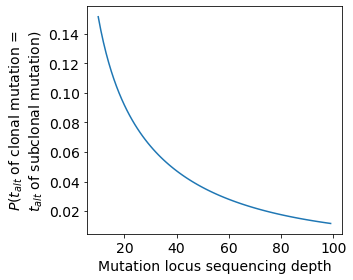

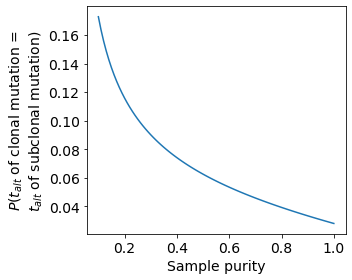

In [4]:
# FIGURE SN1.1

def convolve_binomal_pmfs(ppvaf1, purity1, ppvaf2, purity2, depth):
    all_alts = np.arange(depth+1)
    
    vaf1 = purity1 * ppvaf1 / 2
    vaf2 = purity2 * ppvaf2 / 2
    
    pmf1 = binom.pmf(all_alts, depth, vaf1)
    pmf2 = binom.pmf(all_alts, depth, vaf2)
    return np.dot(pmf1, pmf2)

ccf_sweep = np.linspace(0,1,101)
to_plot = []
for ccf in ccf_sweep:
    to_plot.append(convolve_binomal_pmfs(1, 1, ccf, 1, 60))
    
fig, ax = plt.subplots(1,1, figsize=(5,4))
plt.plot(ccf_sweep, to_plot)
plt.xlabel("ppVAF of subclonal mutation", fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("$P(t_{alt}$ of clonal mutation =\n$t_{alt}$ of subclonal mutation)", fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"FigST1a_overlap_sweep_ppVAF.pdf")
plt.show()


depth_sweep = np.arange(10, 100)
to_plot = []
for depth in depth_sweep:
    to_plot.append(convolve_binomal_pmfs(1, 1, 0.75, 1, depth))

fig, ax = plt.subplots(1,1, figsize=(5,4))
plt.plot(depth_sweep, to_plot)
plt.xlabel("Mutation locus sequencing depth", fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("$P(t_{alt}$ of clonal mutation =\n$t_{alt}$ of subclonal mutation)", fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"FigST1b_overlap_sweep_depth.pdf")
plt.show()

purity_sweep = np.linspace(0.1,1,91)
to_plot = []
for purity in purity_sweep:
    to_plot.append(convolve_binomal_pmfs(1, purity, 0.75, purity, 60))
    
fig, ax = plt.subplots(1,1, figsize=(5,4))
plt.plot(purity_sweep, to_plot)
plt.xlabel("Sample purity", fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("$P(t_{alt}$ of clonal mutation =\n$t_{alt}$ of subclonal mutation)", fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"FigST1c_overlap_sweep_purity.pdf")
plt.show()

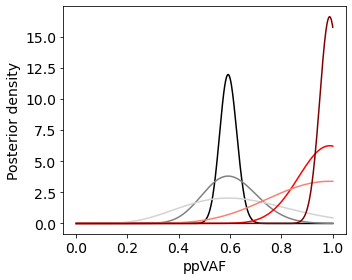

In [5]:
# FIGURE SN1.2a

true_ppVAF = 1
purity = 0.8
t_depth = 100

t_alt = int(np.round(t_depth*true_ppVAF*purity/2))
                 
ppVAF_clonal_100 = single_diploid_mutation_posterior(t_alt, t_depth, purity)

true_ppVAF = 1
purity = 0.8
t_depth = 25

t_alt = int(np.round(t_depth*true_ppVAF*purity/2))
                 
ppVAF_clonal_25 = single_diploid_mutation_posterior(t_alt, t_depth, purity)

true_ppVAF = 0.6
purity = 0.8
t_depth = 100

t_alt = int(np.round(t_depth*true_ppVAF*purity/2))
                 
ppVAF_06_100 = single_diploid_mutation_posterior(t_alt, t_depth, purity)

true_ppVAF = 0.6
purity = 0.8
t_depth = 25

t_alt = int(np.round(t_depth*true_ppVAF*purity/2))
                 
ppVAF_06_25 = single_diploid_mutation_posterior(t_alt, t_depth, purity)

true_ppVAF = 0.6
purity = 0.8
t_depth = 1000

t_alt = int(np.round(t_depth*true_ppVAF*purity/2))
                 
ppVAF_06_1000 = single_diploid_mutation_posterior(t_alt, t_depth, purity)

true_ppVAF = 1
purity = 0.8
t_depth = 1000

t_alt = int(np.round(t_depth*true_ppVAF*purity/2))
                 
ppVAF_clonal_1000 = single_diploid_mutation_posterior(t_alt, t_depth, purity)

fig, ax = plt.subplots(1,1, figsize=(5,4))
plt.plot(np.linspace(0.001, 1, 1000), ppVAF_06_1000, color="k")
plt.plot(np.linspace(0.001, 1, 1000), ppVAF_06_100, color="grey")
plt.plot(np.linspace(0.001, 1, 1000), ppVAF_06_25, color="lightgrey")
plt.plot(np.linspace(0.001, 1, 1000), ppVAF_clonal_100, color="red")
plt.plot(np.linspace(0.001, 1, 1000), ppVAF_clonal_25, color="salmon")
plt.plot(np.linspace(0.001, 1, 1000), ppVAF_clonal_1000, color="maroon")
#plt.axvline(x=0.6, color="k", linestyle="dashed")
plt.xlabel("ppVAF", fontsize=14)
plt.ylabel("Posterior density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"FigST2a_posterior_overlaps.pdf")
plt.show()

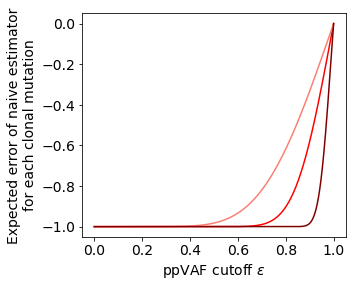

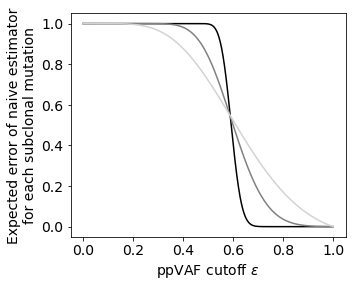

In [6]:
# FIGURE SN1.2b-c

fig, ax = plt.subplots(1,1, figsize=(5,4))
plt.plot(np.linspace(0.001, 1, 1000), np.cumsum(ppVAF_clonal_100)/1000 - 1, color="red")
plt.plot(np.linspace(0.001, 1, 1000), np.cumsum(ppVAF_clonal_25)/1000 - 1, color="salmon")
plt.plot(np.linspace(0.001, 1, 1000), np.cumsum(ppVAF_clonal_1000)/1000 - 1, color="maroon")

plt.xlabel("ppVAF cutoff $\epsilon$", fontsize=14)
plt.ylabel("Expected error of naive estimator\nfor each clonal mutation", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"FigST2b_clonal_error.pdf")
plt.show()

fig, ax = plt.subplots(1,1, figsize=(5,4))
plt.plot(np.linspace(0.001, 1, 1000), 1-np.cumsum(ppVAF_06_1000)/1000, color="k")
plt.plot(np.linspace(0.001, 1, 1000), 1-np.cumsum(ppVAF_06_100)/1000, color="grey")
plt.plot(np.linspace(0.001, 1, 1000), 1-np.cumsum(ppVAF_06_25)/1000, color="lightgrey")

plt.xlabel("ppVAF cutoff $\epsilon$", fontsize=14)
plt.ylabel("Expected error of naive estimator\nfor each subclonal mutation", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"FigST2c_subclonal_error.pdf")
plt.show()

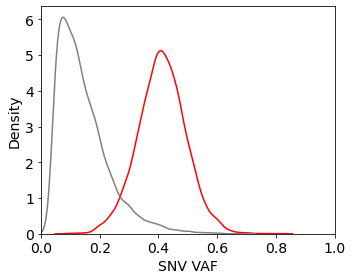

In [7]:
# FIGURE SN1.3a

fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.kdeplot(simulated_clonal_WGS["vaf"], color="red", ax=ax)
sns.kdeplot(true_subclonal_WGS["vaf"], color="grey", ax=ax)
plt.xlabel("SNV VAF", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,1)
plt.tight_layout()

if save_plots:
    plt.savefig(plots_dir+"FigST3a_ground_truth_vafs.pdf")
plt.show()

In [8]:
n_muts = 1000
n_iter = 50
clonal_freq_sweep = np.linspace(0,1,11)

threshold_name = "clonal_cont_0.8"
freqs = []
count = 0

to_concat = []
for clonal_freq in clonal_freq_sweep:
    for i in range(n_iter):
        sampled_clonal = np.random.choice(len(simulated_clonal_WGS), size=int(clonal_freq * n_muts), replace=False)
        sampled_clonal = simulated_clonal_WGS.iloc[sampled_clonal]
        sampled_clonal["Tumor_Sample_Barcode"] = "freq_"+str(clonal_freq)+"_sim_run_"+str(i)
        to_concat.append(sampled_clonal)

        sampled_subclonal = np.random.choice(len(true_subclonal_WGS), size=int((1-clonal_freq) * n_muts), replace=False)
        sampled_subclonal = true_subclonal_WGS[sampled_clonal.columns].iloc[sampled_subclonal]
        sampled_subclonal["Tumor_Sample_Barcode"] = "freq_"+str(clonal_freq)+"_sim_run_"+str(i)
        to_concat.append(sampled_subclonal)

        freqs.append(clonal_freq)
        count += 1
sim_results = pd.concat(to_concat, ignore_index=True)
n_clonal, sim_results_clonal = add_count_clonal(sim_results, threshold_name, simulated_clonal_WGS, true_subclonal_WGS, 63)
n_clonal["true_clonal_freq"] = [float(x.split("_")[1]) for x in n_clonal.index]
n_clonal["estim_clonal_freq"] = n_clonal["final_clonal"]/n_clonal["total_muts"]

/tmp/ipykernel_212708/3983214765.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_clonal["Tumor_Sample_Barcode"] = "freq_"+str(clonal_freq)+"_sim_run_"+str(i)
<string>:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


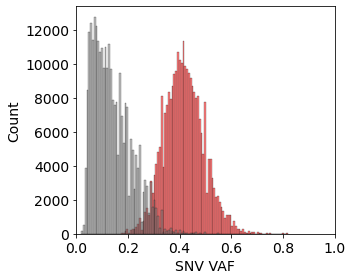

In [9]:
# FIGURE SN1.3b

fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.histplot(x=sim_results_clonal["vaf"], hue=sim_results_clonal["final_clonal"], palette=["grey", "red"], ax=ax, legend=False)
plt.xlabel("SNV VAF", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,1)
plt.tight_layout()

if save_plots:
    plt.savefig(plots_dir+"FigST3b_simulated_classified.pdf")

plt.show()

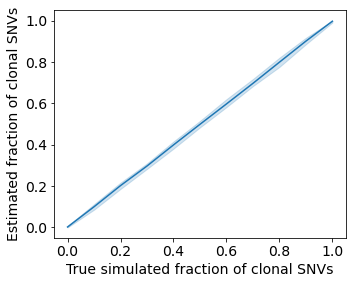

In [10]:
# FIGURE SN1.3c

fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.lineplot(x=n_clonal["true_clonal_freq"], y=n_clonal["estim_clonal_freq"], errorbar="pi")
plt.xlabel("True simulated fraction of clonal SNVs", fontsize=14)
plt.ylabel("Estimated fraction of clonal SNVs", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if save_plots:
    plt.savefig(plots_dir+"FigST3c_simulated_nclonal.pdf")
plt.show()

In [11]:
def kmeans_cluster_clonal(maf):
    to_test = maf[np.logical_and(maf["tcn"]==2, maf["lcn"]==1)]
    gm_fit = KMeans(n_clusters=2).fit_predict(to_test["vaf"].values.reshape(-1,1))
    to_test["class"] = gm_fit
    if np.mean(to_test[to_test["class"] == 0]["vaf"]) > np.mean(to_test[to_test["class"] == 1]["vaf"]):
        clonal = 0
    else:
        clonal = 1
    to_test["is_clonal_cluster"] = to_test["class"] == clonal
    return to_test

clonal_peaks = ["A001C102", "A002C010", "A002C016", "A002C203", "A002C204", "F007", "F008", "F037", "F072B", "F073B", "F074B", "F088B", "G024", "G025", "G044"]
n_clonal_clustering = []
means_clonal_peak = []

all_clustered_mafs = {}

for i,sample in enumerate(clonal_peaks):
    #print(sample)
    to_test = kmeans_cluster_clonal(only_SNVs_WGS[only_SNVs_WGS["Tumor_Sample_Barcode"] == sample])
    
    means_clonal_peak.append(np.mean(to_test[to_test["is_clonal_cluster"]]["vaf"]))
    n_clonal_clustering.append(np.sum(to_test["is_clonal_cluster"]))
    
    all_clustered_mafs[sample] = to_test
n_clonal_clustering = pd.DataFrame({"cluster_clonal":n_clonal_clustering, "mean_peak":means_clonal_peak}, index=clonal_peaks)

/tmp/ipykernel_212708/2045078866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_test["class"] = gm_fit
/tmp/ipykernel_212708/2045078866.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_test["is_clonal_cluster"] = to_test["class"] == clonal
/tmp/ipykernel_212708/2045078866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

/tmp/ipykernel_212708/2045078866.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_test["is_clonal_cluster"] = to_test["class"] == clonal
/tmp/ipykernel_212708/2045078866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_test["class"] = gm_fit
/tmp/ipykernel_212708/2045078866.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

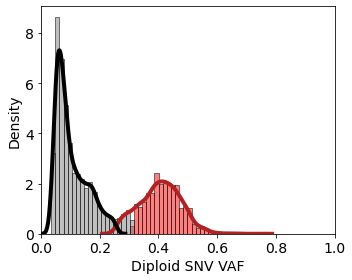

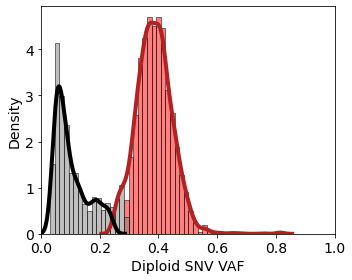

/tmp/ipykernel_212708/2045078866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_test["class"] = gm_fit
/tmp/ipykernel_212708/2045078866.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_test["is_clonal_cluster"] = to_test["class"] == clonal


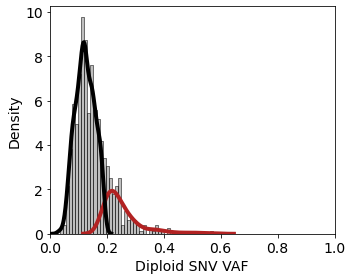

/tmp/ipykernel_212708/2045078866.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_test["class"] = gm_fit
/tmp/ipykernel_212708/2045078866.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_test["is_clonal_cluster"] = to_test["class"] == clonal


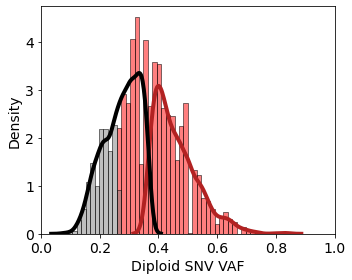

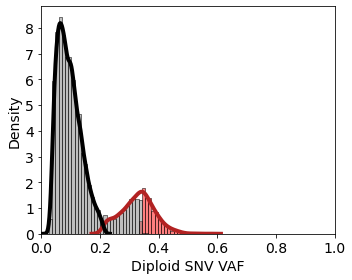

In [12]:
# FIGURE SN1.4a-c

to_plot = all_clustered_mafs["A002C010"]

fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.histplot(x=to_plot["vaf"], hue=to_plot["final_clonal"], palette=["grey", "red"], ax=ax, stat="density", bins=50, legend=False)
sns.kdeplot(x=to_plot["vaf"], hue=to_plot["is_clonal_cluster"], palette=["black", "firebrick"], ax=ax, legend=False, linewidth=4)

plt.xlabel("Diploid SNV VAF", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,1)
plt.tight_layout()

if save_plots:
    plt.savefig(plots_dir+"FigST4a_clustered_A002C010.pdf")
plt.show()

to_plot = all_clustered_mafs["F073B"]

fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.histplot(x=to_plot["vaf"], hue=to_plot["final_clonal"], palette=["grey", "red"], ax=ax, stat="density", bins=50, legend=False)
sns.kdeplot(x=to_plot["vaf"], hue=to_plot["is_clonal_cluster"], palette=["black", "firebrick"], ax=ax, legend=False, linewidth=4)

plt.xlabel("Diploid SNV VAF", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,1)
plt.tight_layout()

if save_plots:
    plt.savefig(plots_dir+"FigST4b_clustered_F07EB.pdf")
plt.show()

to_plot = kmeans_cluster_clonal(only_SNVs_WGS[only_SNVs_WGS["Tumor_Sample_Barcode"] == "A001C021"])

fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.histplot(x=to_plot["vaf"], hue=to_plot["final_clonal"], palette=["grey", "red"], ax=ax, stat="density", bins=50, legend=False)
sns.kdeplot(x=to_plot["vaf"], hue=to_plot["is_clonal_cluster"], palette=["black", "firebrick"], ax=ax, legend=False, linewidth=4)

plt.xlabel("Diploid SNV VAF", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,1)
plt.tight_layout()

if save_plots:
    plt.savefig(plots_dir+"FigST4c_clustered_A001C021.pdf")
plt.show()

to_plot = kmeans_cluster_clonal(only_SNVs_WGS[only_SNVs_WGS["Tumor_Sample_Barcode"] == "G6B"])

fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.histplot(x=to_plot["vaf"], hue=to_plot["final_clonal"], palette=["grey", "red"], ax=ax, stat="density", bins=50, legend=False)
sns.kdeplot(x=to_plot["vaf"], hue=to_plot["is_clonal_cluster"], palette=["black", "firebrick"], ax=ax, legend=False, linewidth=4)

plt.xlabel("Diploid SNV VAF", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,1)
plt.tight_layout()

if save_plots:
    plt.savefig(plots_dir+"FigST4d_clustered_G6B.pdf")
plt.show()


to_plot = all_clustered_mafs["F007"]

fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.histplot(x=to_plot["vaf"], hue=to_plot["final_clonal"], palette=["grey", "red"], ax=ax, stat="density", bins=50, legend=False)
sns.kdeplot(x=to_plot["vaf"], hue=to_plot["is_clonal_cluster"], palette=["black", "firebrick"], ax=ax, legend=False, linewidth=4)

plt.xlabel("Diploid SNV VAF", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,1)
plt.tight_layout()

if save_plots:
    plt.savefig(plots_dir+"FigST4e_clustered_F007.pdf")
plt.show()

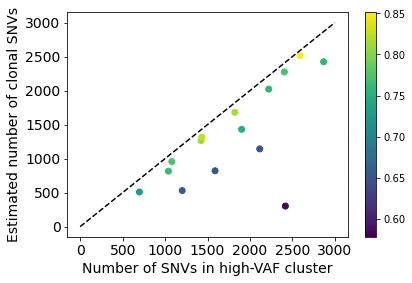

In [13]:
# FIGURE SN1.4f

diploid_clonal = only_SNVs_WGS[np.logical_and(only_SNVs_WGS["tcn"]==2, only_SNVs_WGS["lcn"]==1)]
diploid_clonal = diploid_clonal[["Tumor_Sample_Barcode", "final_clonal"]].groupby("Tumor_Sample_Barcode").sum()

to_plot = n_clonal_clustering.join(diploid_clonal, how="inner")

fig, ax = plt.subplots(1,1, figsize=(6,4))
sc = ax.scatter(to_plot["cluster_clonal"], to_plot["final_clonal"], c=to_plot["mean_peak"]*2)
fig.colorbar(sc)
plt.plot([0,3000], [0,3000], color="k", linestyle="dashed")

plt.xlabel("Number of SNVs in high-VAF cluster", fontsize=14)
plt.ylabel("Estimated number of clonal SNVs", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if save_plots:
    plt.savefig(plots_dir+"FigST4f_clustered_nclonal.pdf")
plt.show()

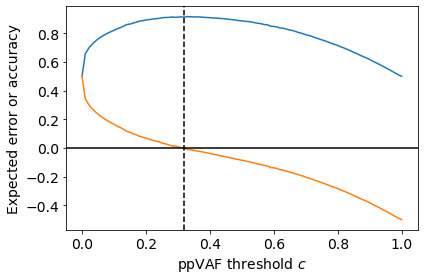

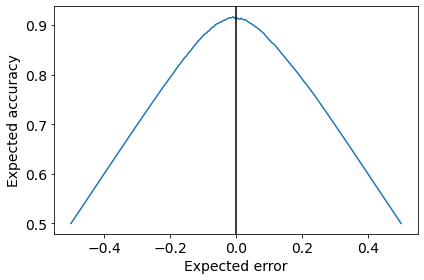

In [14]:
# FIGURE SN1.5a-b

optimum_5, expected_error_5, subclonal_accuracies_5, clonal_accuracies_5, mean_accuracies_5 = optimize_cutoff("clonal_cont_0.8", simulated_clonal_WGS, true_subclonal_WGS, 0.5, return_diagnostic=True)

cutoffs = np.linspace(0, 1, 101)

fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(cutoffs, mean_accuracies_5)
plt.plot(cutoffs, expected_error_5)
plt.axvline(x=optimum_5, color="k", linestyle="dashed")
plt.axhline(y=0, color="k")

plt.xlabel("ppVAF threshold $c$", fontsize=14)
plt.ylabel("Expected error or accuracy", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if save_plots:
    plt.savefig(plots_dir+"FigST5a_threshold_sweep.pdf")
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(expected_error_5, mean_accuracies_5)
plt.axvline(x=0, color="k")
plt.xlabel("Expected error", fontsize=14)
plt.ylabel("Expected accuracy", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if save_plots:
    plt.savefig(plots_dir+"FigST5b_error_accuracy.pdf")
plt.show()